# Train a model to predict log(Sigma_E0) value at Room Temperature (Starry all)-Solid solution (lolopy)

### Created the half-heusler dataset from Starry database 

In [1]:
%matplotlib inline
import matminer
import matminer.utils
from lolopy.learners import RandomForestRegressor
from matminer.data_retrieval import retrieve_MDF
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor as SKRFRegressor
from scipy.stats import norm
#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold
import gzip
import os
import re
import csv
import datetime
import glob
import json

/home/unmagna/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load Training Set

In [2]:
#data  = pd.read_csv('C:/Users/sarker/Documents/Document/matminer_copy/Half_Heusler/raw/HH_review_total_github_modified.csv' )
#data  = pd.read_csv('/home/unmagna/Documents/slac/matminer/Half_Heusler/raw/HH_review_total_sigma_E0_master_1.csv' )
#data = pd.read_csv('/home/unmagna/Documents/slac/matminer/Half_Heusler/raw/HH_review_total_edited_Lattice_Thermal_Conductivity_master.csv')
data = pd.read_csv('/home/unmagna/Documents/slac/matminer/Nov2022/TC/data/HH_review_total_edited_Lattice_Thermal_Conductivity_master_manual_Nov22.csv')
data.head()

,REFERENCE: doi,FORMULA,IDENTIFIER: sampleid,PROPERTY: Temperature (K),PROPERTY: Seebeck coefficient (V/K),PROPERTY: Thermal conductivity (W*m^(-1)*K^(-1)),PROPERTY: Power factor (W*m^(-1)*K^(-2)),PROPERTY: ZT (-),PROPERTY: Electrical conductivity (S*m^(-1)),PROPERTY: sigma_E_0,PROPERTY: log sigma_E_0,PROPERTY: quality_factor,PROPERTY: log quality_factor,PROPERTY: Seebeck coefficient (muV/K),|S|(muV/K),Unnamed: 15,L,L-unit con,Electronic thermal conductivity,Lattice thermal conductivity
0,10.1103/physrevb.85.144120,Mg1 Ag1 Sb1,13325,300.0,0.000075,1.160706,0.000883,0.364145,159606.145900,44460.20650,4.647971,0.552491,NaN,75.225793,75.225793,0.522830,2.022830,2.020000e-08,0.968568,0.192138
1,10.1007/s11664-010-1278-1,Ag0.355875 Sb0.54405 Te1 Ge0.025,16730,300.0,0.000059,0.819577,NaN,0.123766,88415.512830,18888.16575,4.276190,0.169489,NaN,59.419064,59.419064,0.599156,2.099156,2.100000e-08,0.556794,0.262783
2,10.1021/ja403653m,Ca0.84 Ce0.16 Ag0.9 Sb1,13266,300.0,0.000070,0.629979,NaN,0.158819,54753.521130,14031.83081,4.147114,0.108597,NaN,69.998214,69.998214,0.546931,2.046931,2.050000e-08,0.336230,0.293749
3,10.1063/1.2756037,Ag0.9 Cu0.1 Tl1 Te1,14176,300.0,0.000502,0.354364,0.000062,0.061798,266.974996,12221.74494,4.087133,0.077093,NaN,501.855670,501.855670,0.013216,1.513216,1.510000e-08,0.001212,0.353152
4,10.1063/1.2756037,Ag0.7 Cu0.3 Tl1 Te1,14178,300.0,0.000391,0.366931,0.000144,0.126461,873.326162,11086.85850,4.044809,0.068040,NaN,391.340206,391.340206,0.034265,1.534265,1.530000e-08,0.004020,0.362911


In [3]:
print(len(data))
data.head()

636


,REFERENCE: doi,FORMULA,IDENTIFIER: sampleid,PROPERTY: Temperature (K),PROPERTY: Seebeck coefficient (V/K),PROPERTY: Thermal conductivity (W*m^(-1)*K^(-1)),PROPERTY: Power factor (W*m^(-1)*K^(-2)),PROPERTY: ZT (-),PROPERTY: Electrical conductivity (S*m^(-1)),PROPERTY: sigma_E_0,PROPERTY: log sigma_E_0,PROPERTY: quality_factor,PROPERTY: log quality_factor,PROPERTY: Seebeck coefficient (muV/K),|S|(muV/K),Unnamed: 15,L,L-unit con,Electronic thermal conductivity,Lattice thermal conductivity
0,10.1103/physrevb.85.144120,Mg1 Ag1 Sb1,13325,300.0,0.000075,1.160706,0.000883,0.364145,159606.145900,44460.20650,4.647971,0.552491,NaN,75.225793,75.225793,0.522830,2.022830,2.020000e-08,0.968568,0.192138
1,10.1007/s11664-010-1278-1,Ag0.355875 Sb0.54405 Te1 Ge0.025,16730,300.0,0.000059,0.819577,NaN,0.123766,88415.512830,18888.16575,4.276190,0.169489,NaN,59.419064,59.419064,0.599156,2.099156,2.100000e-08,0.556794,0.262783
2,10.1021/ja403653m,Ca0.84 Ce0.16 Ag0.9 Sb1,13266,300.0,0.000070,0.629979,NaN,0.158819,54753.521130,14031.83081,4.147114,0.108597,NaN,69.998214,69.998214,0.546931,2.046931,2.050000e-08,0.336230,0.293749
3,10.1063/1.2756037,Ag0.9 Cu0.1 Tl1 Te1,14176,300.0,0.000502,0.354364,0.000062,0.061798,266.974996,12221.74494,4.087133,0.077093,NaN,501.855670,501.855670,0.013216,1.513216,1.510000e-08,0.001212,0.353152
4,10.1063/1.2756037,Ag0.7 Cu0.3 Tl1 Te1,14178,300.0,0.000391,0.366931,0.000144,0.126461,873.326162,11086.85850,4.044809,0.068040,NaN,391.340206,391.340206,0.034265,1.534265,1.530000e-08,0.004020,0.362911


### Choosing columns

In [4]:
data = data[['FORMULA', 'Lattice thermal conductivity']]
#data = data[['FORMULA', 'PROPERTY: log sigma_E_0']]
data.head()

,FORMULA,Lattice thermal conductivity
0,Mg1 Ag1 Sb1,0.192138
1,Ag0.355875 Sb0.54405 Te1 Ge0.025,0.262783
2,Ca0.84 Ce0.16 Ag0.9 Sb1,0.293749
3,Ag0.9 Cu0.1 Tl1 Te1,0.353152
4,Ag0.7 Cu0.3 Tl1 Te1,0.362911


#### Change the column name

In [5]:
#data = data.rename(columns={ 'FORMULA':'composition', 'PROPERTY: log sigma_E_0': 'log_sig_E0'})
data = data.rename(columns={ 'FORMULA':'composition', 'Lattice thermal conductivity': 'L_TC'})

### All data together

In [6]:

data = StrToComposition(target_col_id='composition_obj').featurize_dataframe(data, ['composition'], ignore_errors=True);


#data = feature_calculators.featurize_dataframe(data, col_id=['composition_obj'], ignore_errors=True);

In [7]:
print(len(data))
#print(data)
data.head()

636


,composition,L_TC,composition_obj
0,Mg1 Ag1 Sb1,0.192138,"(Mg, Ag, Sb)"
1,Ag0.355875 Sb0.54405 Te1 Ge0.025,0.262783,"(Ag, Sb, Te, Ge)"
2,Ca0.84 Ce0.16 Ag0.9 Sb1,0.293749,"(Ca, Ce, Ag, Sb)"
3,Ag0.9 Cu0.1 Tl1 Te1,0.353152,"(Ag, Cu, Tl, Te)"
4,Ag0.7 Cu0.3 Tl1 Te1,0.362911,"(Ag, Cu, Tl, Te)"


In [8]:
for k in ['L_TC']:
    data[k] = pd.to_numeric(data[k])

#for k in ['log_sig_E0']:
#    data[k] = pd.to_numeric(data[k])

In [9]:
original_count = len(data)
data = data[~ data['L_TC'].isnull()]
#data = data[~ data['log_sig_E0'].isnull()]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 0/636 entries


## Final processed data

In [10]:

%%time

original_count = len(data)
data['composition'] = data['composition_obj'].apply(lambda x: x.reduced_formula)
data.sort_values('L_TC', ascending=True, inplace=True)
#data.sort_values('log_sig_E0', ascending=True, inplace=True)
data.drop_duplicates ('composition', keep='last', inplace=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))
data.head()
#data.to_csv ( 'processed.csv')

Removed 172/636 entries
CPU times: user 54.1 ms, sys: 1.69 ms, total: 55.8 ms
Wall time: 55.4 ms


,composition,L_TC,composition_obj
0,MgAgSb,0.192138,"(Mg, Ag, Sb)"
1,Ag0.355875Ge0.025Sb0.54405Te1,0.262783,"(Ag, Sb, Te, Ge)"
2,Ca0.84Ce0.16Ag0.9Sb1,0.293749,"(Ca, Ce, Ag, Sb)"
3,Tl1Cu0.1Ag0.9Te1,0.353152,"(Ag, Cu, Tl, Te)"
4,Tl1Cu0.3Ag0.7Te1,0.362911,"(Ag, Cu, Tl, Te)"


In [11]:
original_count = len(data)
#print(data)
#data = data[np.logical_and(data['log_sig_E0'] >= 3.5, data['log_sig_E0'] <= 6.3)]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 0/464 entries


# Build an ML model

Part 1: Compute Representation

The first step in building a ML model is to convert the raw materials data (here: the composition) into the required input for an ML model: a finite list of quantitative attributes. In this example, we use the "general-purpose" attributes of Ward et al 2016.

In [12]:
f =  MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])

### Get the feature names

In [13]:

feature_labels = f.feature_labels()
#print(feature_labels)


### Compute the features

In [14]:
%%time
data = f.featurize_dataframe(data, col_id=['composition_obj'], ignore_errors=True);


CPU times: user 237 ms, sys: 47.7 ms, total: 285 ms
Wall time: 1.81 s


### Remove entries with NaN or infinite features

In [15]:
original_count = len(data)

data = data[~ data[feature_labels].isnull().any(axis=1)]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 0/464 entries


In [16]:
X = np.array(f.featurize_many(data['composition_obj']))


In [17]:
#X = np(data[feature_labels])
y = np.array(data['L_TC'])
#y = np.array(data['log_sig_E0'])
#X = np.array(data[feature_labels])
y1 = pd.DataFrame(y)
y1.head()

,0
0,0.192138
1,0.262783
2,0.293749
3,0.353152
4,0.362911


# Sklearn model

Tuning Model Hyper-parameters

"Random forest" algorithm works by training many different decision tree models, where each is trained on a different subset of the dataset . Here, we tune one of the major parameters of the algorithm: the number features considered at each split in each decision tree


In [18]:
SK_model = GridSearchCV(SKRFRegressor(n_estimators=20, n_jobs=-1),
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',cv=ShuffleSplit(n_splits=1, test_size=0.2))

In [19]:
%%time 
SK_model.fit(X, y)

CPU times: user 465 ms, sys: 91 ms, total: 556 ms
Wall time: 2.12 s


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=20, n_jobs=-1,
                                             oob_score=False, random_state=None,
                          

In [20]:
SK_model.best_score_

-4.207379175182285

Text(0, 0.5, 'Sigma_E0')

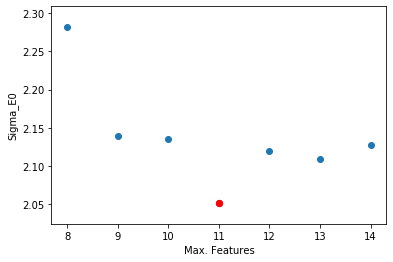

In [21]:
fig, ax = plt.subplots()

# Plot the score as a function of alpha
ax.scatter(SK_model.cv_results_['param_max_features'].data,
          np.sqrt(-1 * SK_model.cv_results_['mean_test_score']))
ax.scatter([SK_model.best_params_['max_features']], np.sqrt([-1*SK_model.best_score_]), marker='o', color='r', s=40)
ax.set_xlabel('Max. Features')
ax.set_ylabel('Sigma_E0')

In [22]:

SK_model = SK_model.best_estimator_

In [23]:
%%time
sk_pred = SK_model.predict(X)

CPU times: user 7.92 ms, sys: 791 µs, total: 8.71 ms
Wall time: 105 ms


## Cross-validation Test

Quantify the performance of this model using 10-fold cross-validation


In [24]:
cv_prediction = cross_val_predict(SK_model,X,y, cv=KFold(10, shuffle=True))


#print(cv_prediction)
#print(len(cv_prediction))
#cv_pred = pd.DataFrame(cv_prediction)
cv_pred = pd.DataFrame(cv_prediction)

## Creating SKlearn csv

In [25]:
#create_xcl_sklearn = pd.DataFrame
create_xcl_sklearn = pd.DataFrame(data, columns = ['composition', 'composition_obj', 'L_TC'])
create_xcl_sklearn = create_xcl_sklearn .reset_index(drop= True)
create_xcl_sklearn = pd.concat([create_xcl_sklearn , cv_pred], axis = 1, ignore_index=True)
create_xcl_sklearn.head()

create_xcl_sklearn = pd.DataFrame(create_xcl_sklearn).reset_index()
create_xcl_sklearn.columns = ['index','composition','composition_obj',  'lattice TC', 'Predicted TC']
#print((create_xcl_predZT))
create_xcl_sklearn.head()
#create_xcl_sklearn.to_csv('Sk_learn_predicted.csv')

,index,composition,composition_obj,lattice TC,Predicted TC
0,0,MgAgSb,"(Mg, Ag, Sb)",0.192138,1.322991
1,1,Ag0.355875Ge0.025Sb0.54405Te1,"(Ag, Sb, Te, Ge)",0.262783,0.696946
2,2,Ca0.84Ce0.16Ag0.9Sb1,"(Ca, Ce, Ag, Sb)",0.293749,0.891525
3,3,Tl1Cu0.1Ag0.9Te1,"(Ag, Cu, Tl, Te)",0.353152,0.430261
4,4,Tl1Cu0.3Ag0.7Te1,"(Ag, Cu, Tl, Te)",0.362911,0.385260


### Compute aggregate statistics

In [26]:
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(metrics,scorer)(y, cv_prediction)
    print(scorer, score)

r2_score 0.7437919857107518
mean_absolute_error 1.0663202194998709
mean_squared_error 3.1712860699662824


# lolopy model

In [27]:
model = RandomForestRegressor(num_trees=20)

#num_trees=-1, use_jackknife=True, bias_learner=None,
 #                leaf_learner=None, subset_strategy="auto", min_leaf_instances=1,
  #               max_depth=2**30, uncertainty_calibration=False, randomize_pivot_location=False,
   #              randomly_rotate_features=False

#model = GridSearchCV(RandomForestRegressor(num_trees=20)),
 #                    param_grid=dict(max_features=range(8,15)),
  #                   scoring='neg_mean_squared_error',cv=ShuffleSplit(n_splits=1, test_size=0.1))

#model = GridSearchCV(RandomForestRegressor(num_trees=20),
#                     param_grid=dict(max_features=range(8,15)),
 #                    scoring='neg_mean_squared_error',cv=ShuffleSplit(n_splits=1, test_size=0.1))
#SKRFRegressor(n_estimators=len(X))



In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#SK_model
#sk_rf = RandomForestRegressor()
#lolo_rf = Lolo_RF()
model.fit(X_train, y_train)

RandomForestRegressor(bias_learner=None, leaf_learner=None,
                      max_depth=1073741824, min_leaf_instances=1, num_trees=20,
                      randomize_pivot_location=False,
                      randomly_rotate_features=False, subset_strategy='auto',
                      uncertainty_calibration=False, use_jackknife=True)

### Get the Residuals and RF Uncertainty
copied from exacmple "As described in the Ling paper, ideally-calibrated uncertainty estimaes should have a particular relationship with the errors of a machine learning model. Specifically, the distribution of r(x)/σ(x) where r(x) is the residual of the prediction and σ(x) is the uncertainty of the prediction for x should have a Gaussian distribution with zero mean and unit standard deviation."

Get the errors from 10-fold cross-validation

In [29]:
y_resid = []
y_uncer = []
for train_id, test_id in KFold(10, shuffle=True).split(X):
    model.fit(X[train_id], y[train_id])
    yf_pred, yf_std = model.predict(X[test_id], return_std=True)
    y_resid.extend(yf_pred - y[test_id])
    y_uncer.extend(yf_std)

In [30]:
y_residual = pd.DataFrame(y_resid)

In [31]:
#pred vs. actual on test set
from sklearn import metrics

y_pred = model.predict(X_test)
errors = abs(y_pred - y_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.4405337206053762
Mean Squared Error: 0.49430875321085876
Root Mean Squared Error: 0.7030709446498687


## Cross-validation Test lolopy

Quantify the performance of this model using 10-fold cross-validation


In [32]:
cv_prediction1 = cross_val_predict(model,X,y, cv=KFold(10, shuffle=True))

In [33]:
for scorer1 in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score1 = getattr(metrics,scorer1)(y, cv_prediction1)
    print(scorer1, score1)

r2_score 0.7444991456389025
mean_absolute_error 1.0438421320474138
mean_squared_error 3.162533000958648


In [34]:
lolo_pred, lolo_std = model.predict(X, return_std=True)
#print(lolo_pred)
#lolo_pred, lolo_std = model.predict(X, return_std=True)
len(lolo_pred)

464

In [35]:
lolo_predict = pd.DataFrame(lolo_pred)
lolo_standard = pd.DataFrame(lolo_std)
#lolo_standard.head()


In [36]:
mli_score = (np.divide(((lolo_pred) - np.min(y_train)), (lolo_std)))
cmin = np.min(y_train)
print(cmin)

0.192137609


## Plot the individual predictions

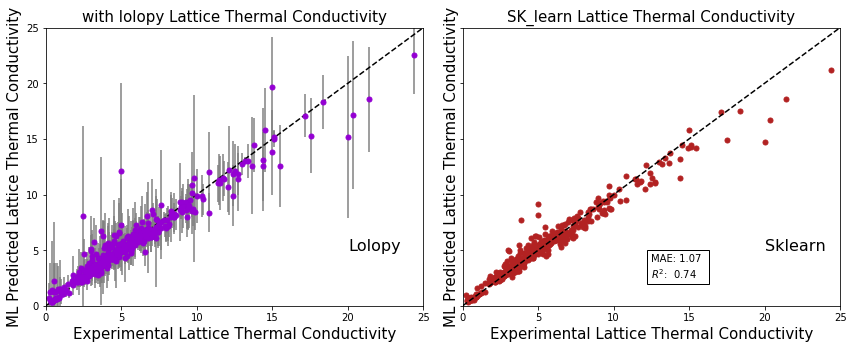

In [53]:
fig, axs = plt.subplots(1, 2, sharey=True)
#fig, ax = plt.subplots()

axs[0].errorbar(y, lolo_pred, lolo_std, fmt='o', ms=5, color = 'darkviolet', ecolor='gray')
axs[1].scatter(y, sk_pred, s=25, color = 'firebrick')
#axs.set_title('Starry Lattice Thermal Conductivity (All Data)')

#axs[0].set_title('with lolopy Sigma_E0', fontsize = 15)
#axs[1].set_title('SK_learn Sigma_E0', fontsize = 15)
axs[0].set_title('with lolopy Lattice Thermal Conductivity', fontsize = 15)
axs[1].set_title('SK_learn Lattice Thermal Conductivity', fontsize = 15)

lim = [0, 25]
#lim = [0, 25]

for ax, n in zip(axs, ['Lolopy', 'Sklearn']):
    ax.set_xlim(0, 25)
    ax.set_ylim(0, 25)
    ax.set_xlabel('Experimental Lattice Thermal Conductivity',fontsize=15)
    #ax.set_xlabel('Experimental Lattice Thermal Conductivity',fontsize=15)
    ax.plot(lim, lim, 'k--')
    ax.text(20, 5, n, fontsize=16)
    ax.set_ylabel('ML Predicted Lattice Thermal Conductivity', fontsize=15)
    #ax.set_ylabel('ML Lattice Thermal Conductivity', fontsize=15)
    
#lolopy results
mae = metrics.mean_absolute_error(y, cv_prediction1)
          
r2 = metrics.r2_score(y, cv_prediction1)
#ax.text(0.3, 0.1, 'MAE: {:.2f} \n$R^2$:  {:.2f}'.format(mae, r2),
 #       transform=ax.transAxes,
  #   bbox={'facecolor': 'w', 'edgecolor': 'k'})

#SK_learn
mae = metrics.mean_absolute_error(y, cv_prediction)
          
r2 = metrics.r2_score(y, cv_prediction)
ax.text(0.5, 0.1, 'MAE: {:.2f} \n$R^2$:  {:.2f}'.format(mae, r2),
        transform=ax.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

fig.set_size_inches(12, 5)
#fig.set_size_inches(8, 4)
fig.tight_layout()
fig.savefig('/home/unmagna/Documents/slac/matminer/Nov2022/TC/figure/thermal_conductivity_comparison_model_Nov22.png', dpi=500)

# Plot the normalized residuals (r(x)/σ(x)) against the normal distribution

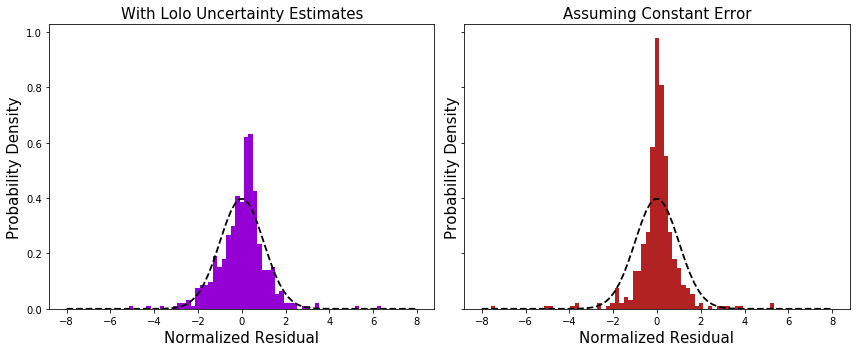

In [54]:
fig, axs = plt.subplots(1, 2, sharey=True)
#f = plt.figure(figsize=(10,3))
#fig.set_size_inches(5, 5)
x = np.linspace(-8, 8, 80)

# Plot the RF uncertainty
resid = np.divide(y_resid, y_uncer)
axs[0].hist(resid, x, density=True, color = 'darkviolet')
axs[0].set_title('With Lolo Uncertainty Estimates', fontsize = 15)

# Plot assuming constant errors
resid = np.divide(y_resid, np.sqrt(np.power(y_resid, 2).mean()))
axs[1].hist(resid, x, density=True, color= 'firebrick')
axs[1].set_title('Assuming Constant Error', fontsize =15)

for ax in axs:
    ax.plot(x, norm.pdf(x), 'k--', lw=1.8)
    ax.set_xlabel('Normalized Residual', fontsize=15)
    ax.set_ylabel('Probability Density', fontsize=15)

fig.set_size_inches(12, 5)
fig.tight_layout()
#print(resid)
fig.savefig('/home/unmagna/Documents/slac/matminer/Nov2022/TC/figure/Probability distribution thermal_conductivity_comparison_nov22.png', dpi=500)

In [51]:

model

RandomForestRegressor(bias_learner=None, leaf_learner=None,
                      max_depth=1073741824, min_leaf_instances=1, num_trees=20,
                      randomize_pivot_location=False,
                      randomly_rotate_features=False, subset_strategy='auto',
                      uncertainty_calibration=False, use_jackknife=True)

### Plot the model

## Save the Sklearn Model

In [55]:
#with gzip.open('lolopy_model_SigmaE0.pkl.gz', 'wb') as fp:
with gzip.open('/home/unmagna/Documents/slac/matminer/Nov2022/TC/results/lolopy_model_TC.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)

#with gzip.open('SK_model_SigmaE0.pkl.gz', 'wb') as fp:
with gzip.open('/home/unmagna/Documents/slac/matminer/Nov2022/TC/results/SK_model_TC.pkl.gz', 'wb') as fp:    
    pkl.dump(SK_model, fp)

In [56]:
with gzip.open('/home/unmagna/Documents/slac/matminer/Nov2022/TC/results/featurizer_TC.pkl.gz', 'wb') as fp:
#with gzip.open('featurizer_SigmaE0.pkl.gz', 'wb') as fp:
    pkl.dump(f, fp)

In [57]:
with open(os.path.join('/home/unmagna/Documents/slac/matminer/Nov2022/TC/results/data_TC.pkl.gz'), 'wb') as fp:
#with open(os.path.join('data_SigmaE0.pkl.gz'), 'wb') as fp:    
    pkl.dump(data, fp)

In [59]:
with open(os.path.join('/home/unmagna/Documents/slac/matminer/Nov2022/TC/results/SK_TC_pred.pkl.gz'), 'wb') as fp:
#with open(os.path.join('SK_sigma_E0_pred.pkl.gz'), 'wb') as fp:    
    pkl.dump(cv_prediction, fp)

with open(os.path.join('/home/unmagna/Documents/slac/matminer/Nov2022/TC/results/lolopy_TC_pred.pkl.gz'), 'wb') as fp:    
#with open(os.path.join('lolopy_sigma_E0_pred.pkl.gz'), 'wb') as fp:
    pkl.dump(cv_prediction1, fp)

In [61]:
with open('/home/unmagna/Documents/slac/matminer/Nov2022/TC/results/SK_learn_TC_cv_prediction.json', 'w') as fp:
#with open('SK_learn_SigmaE0_cv_prediction.json', 'w') as fp:
    json.dump(list(cv_prediction), fp)
    
with open('/home/unmagna/Documents/slac/matminer/Nov2022/TC/results/lolopy_TC_cv_prediction.json', 'w') as fp:    
#with open('lolopy_SigmaE0_cv_prediction.json', 'w') as fp:
    json.dump(list(cv_prediction1), fp)

In [65]:
!pip install pipreqsnb

  Created wheel for pipreqsnb: filename=pipreqsnb-0.2.4-py3-none-any.whl size=4137 sha256=c31ea4f43c0305ae77a5d7af0755104118bdbf9c5b2630543e7bb55921613a1c
  Stored in directory: /home/unmagna/.cache/pip/wheels/23/7f/59/7a87faea552278c8ef0c171ea4d27494eb91ac9380567239b6
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=36aaf4f6755ff312fd151114fe5aa6afc4e0272c18584636aa8205142504a7e9
  Stored in directory: /home/unmagna/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built pipreqsnb docopt


In [67]:
!pipreqsnb . 

pipreqs  .
INFO: Successfully saved requirements file in ./requirements.txt


# Create the ternary with MLI score

In [429]:
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from matplotlib import cm
from pymatgen import Composition
from sklearn.exceptions import NotFittedError
import numpy as np
import ternary
import scipy

def make_cmap(base='plasma_r'): # scale_factor=1, cutoff=0.9, adjust_factor=0.1):
    """Make a colormap that this scaled to emphasize the top of the range.
    
    Two kinds of emphasis:
        1) Scaling the colormap to have a stronger gradient at the top
        2) Making the colors below a treshold lighter
        
    Inputs:
        base - str, base color map name
        scale_factor - float, how much to exaggerate the range at the top (larger value -> larger scaling)
        cutoff - float, treshold below which to lighten colors (0-1)
        adjust_factor - float, how much to dampen colors (0-1)
    Returns:
        Colormap
    """
    
    # Get the base colormap
    v = cm.get_cmap('plasma_r')
    
    # Scale it
    #new_list = v(np.linspace(0,1,50) ** scale_factor)

    # Apply cutoff
   # new_list[:int(len(new_list)*cutoff),:3] += (1 - new_list[:int(len(new_list)*cutoff),:3]) * adjust_factor
    #return ListedColormap(new_list, name='%s_scaled'%base)
    return(v)

#def plot_system(sig_max, sig_min, counter, df, ax, elems, model, featurizer, am_index, scale=3):
def plot_system(df, ax, elems, model, featurizer, am_index, scale=10):
    """Given model output for a ternary, plot the probability of GFA
    
    Args:
        ax: Axis on which to plot
        elems: Elements that define the ternary
        model: Scikit-Learn GFA model
        featurizer: Tool used to generate features for the model
        am_index
    """
    #print(counter)
    #cv_prediction_1=cv_prediction.reshape(1,-1)
    # Make the plot 
    #fig, tax = ternary.figure(scale=scale, ax=ax)
    
    fig, tax = ternary.figure(scale=scale, ax=ax)

    # Make the function
    def get_coords(x):
        #x2 is the composition of the solid solution
        x2 = []
        for x_sub in x:
            x2.append(x_sub/3)
        x2.append(1/3)
        x2.append(1/3)
        #xtype = type(x) 
        print(x2)
        #print(xtype)    
        comp = Composition(dict(zip(elems, x2)))
        #print(comp)
        try:
            X = featurizer.featurize(comp)
            #print(X)
        except: 
            return 0
        #except NotFittedError as e:
         #   print(repr(e))
        #predicted sigma_E0 value
        #retObj = model.predict([X])[0]
        #retObj = model.predict(X)[1][0]
        #return model.predict([X])[1]
        #For predicting new value
        a = model.predict([X])[0]
        #For uncertainty calculations (standard deviation)
        b = model.predict([X], return_std = True)[1][0]
        
        #EI(x)=(μ(x)-f(x^+ )-ϵ)Φ(Z)+σ(x)φ(Z) 
        #μ(x)=a
        #f(x^+ )= cmax
        #σ(x) = b
        z = np.divide((cmin - a), b)
        z_cdf = scipy.stats.norm.cdf(z)
        z_pdf = scipy.stats.norm.pdf(z)
        
        #retObj = np.divide((cmax-a), b)
        #retObj = (cmin - a )*(z_cdf) + (b*z_pdf)
        retObj = b
        x2.append(retObj)
        df.append(x2)
        #print(type(retObj))
        print(retObj)
        
        #counter = counter+1
        return retObj
        
   
    #   Make boundary
    tax.boundary(linewidth=1)
    #sc = tax.heatmapf(get_coords, cmap=make_cmap(), vmin=0.5, vmax=1, colorbar=True)#, cmap='viridis', vmin=0.5, vmax=1)
    #sc = tax.heatmapf(get_coords, cmap=make_cmap(), vmin=cv_prediction.min(), vmax=cv_prediction.max(), colorbar=True)#, cmap='viridis', vmin=0.5, vmax=1)
    coords = get_coords
    #print(type(coords))
    #sc = tax.heatmapf(coords, cmap=make_cmap(), vmin=4.65, vmax=4.91, colorbar=True)
    #sc= tax.heatmapf(coords,style="triangle", cmap=plt.cm.get_cmap('gist_heat'),cbarlabel='Predicted Thermal Conductivity(lolopy)', vmax = 2, vmin = 1.3)

    sc= tax.heatmapf(coords,style="triangle", cmap=plt.cm.get_cmap('viridis_r'),cbarlabel='Predicted Lattice thermal conductivity')
    # Add colorbar
    #cb = plt.colorbar(sc, ax=ax)7
    #cb.ax.set_ylabel('P(GFA = True)')
    
    #for x in cb.ax.get_yticklabels():
    #    x.set_size(10)
    
    # Make it prettier
    plt.axis('off')
    #ax.set_xlim([-5, 110])
    #ax.set_ylim([-5, 110 * 3 ** 0.5 / 2])
    ax.text(1.05 * scale, -0.05 * scale, elems[0], ha='right', fontsize=12) # 1st elem
    ax.text(.50 * scale, .90 * scale, elems[1], ha='center', fontsize=12) # 2nd elem
    ax.text(-.05 * scale, -.05 * scale, elems[2], ha='left', fontsize=12) # 3rd elem

## Load the model

In [407]:
#with gzip.open('SK_model_SigmaE0.pkl.gz', 'rb') as fp:
#with gzip.open('lolopy_model_TC.pkl.gz', 'rb') as fp:
#with gzip.open('lolopy_model_SigmaE0.pkl.gz', 'rb') as fp:
with gzip.open('lolopy_model.pkl.gz', 'rb') as fp:
    model = pkl.load(fp)
    #print(model)

In [408]:
#with gzip.open('featurizer_TC.pkl.gz', 'rb') as fp:
#with gzip.open('featurizer_SigmaE0.pkl.gz', 'rb') as fp:
with gzip.open('featurizer.pkl.gz', 'rb') as fp:
    featurizer = pkl.load(fp)
    #print(featurizer)

In [409]:
#with open('SK_learn_SigmaE0_cv_prediction.json') as fp:
#with open('lolopy_TC_cv_prediction.json') as fp:
#with open('lolopy_SigmaE0_cv_prediction.json') as fp:
with open('cv_prediction_lolopy.json') as fp:
    am_index = json.load(fp)
    #print(am_index)

[0.0, 0.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
4.092071237845187
[0.0, 0.03333333333333333, 0.3, 0.3333333333333333, 0.3333333333333333]
2.3379660463815437
[0.0, 0.06666666666666667, 0.26666666666666666, 0.3333333333333333, 0.3333333333333333]
1.7127467195049968
[0.0, 0.09999999999999999, 0.2333333333333333, 0.3333333333333333, 0.3333333333333333]
0.8218815483997682
[0.0, 0.13333333333333333, 0.19999999999999998, 0.3333333333333333, 0.3333333333333333]
0.6151437910768413
[0.0, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333, 0.3333333333333333]
0.36669798639536766
[0.0, 0.19999999999999998, 0.13333333333333333, 0.3333333333333333, 0.3333333333333333]
0.28606989717704534
[0.0, 0.2333333333333333, 0.09999999999999999, 0.3333333333333333, 0.3333333333333333]
0.27587785228538997
[0.0, 0.26666666666666666, 0.06666666666666667, 0.3333333333333333, 0.3333333333333333]
0.27544497744087865
[0.0, 0.3, 0.03333333333333333, 0.3333333333333333, 0.333333333333333

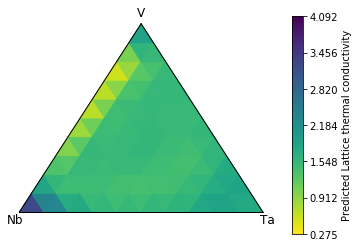

In [430]:
%%time
fig, ax = plt.subplots()
#plot_system(ax, ('Co', 'Ta', 'Sb', 'Fe','Nb'), model, featurizer, am_index)
df_data = []
#sig_max = None
#sig_min = None
#counter = 1
#plot_system(df_data, ax, ('Ta', 'Nb', 'V', 'Fe','Sb'), model, featurizer, am_index)
#plot_system(df_data, ax, ('Hf', 'Ti', 'Zr', 'Ni','Sn'), model, featurizer, am_index)
#plot_system(df_data, ax, ('Ta', 'Nb', 'V', 'Co','Sn'), model, featurizer, am_index)
#plot_system(df_data, ax, ('Hf', 'Ti', 'Zr', 'Co','Sb'), model, featurizer, am_index)
#plot_system(df_data, ax, ('Ta', 'Nb', 'V', 'Co','Sb'), model, featurizer, am_index)
plot_system(df_data, ax, ('Ta', 'V', 'Nb', 'Fe','Sb'), model, featurizer, am_index)
#plot_system(df_data, ax, ('Hf', 'Zr', 'Ti', 'Co','Sb'), model, featurizer, am_index)
#plot_system(df_data, ax, ('Ta', 'V', 'Nb', 'Co','Sn'), model, featurizer, am_index)
#print(df_data) 
#fig.savefig('Brown_TC_lolopy_EI.png', dpi=500)

In [431]:
predicted_data = pd.DataFrame(df_data)

In [432]:
predicted_data.head()

,0,1,2,3,4,5
0,0.0,0.000000,0.333333,0.333333,0.333333,4.092071
1,0.0,0.033333,0.300000,0.333333,0.333333,2.337966
2,0.0,0.066667,0.266667,0.333333,0.333333,1.712747
3,0.0,0.100000,0.233333,0.333333,0.333333,0.821882
4,0.0,0.133333,0.200000,0.333333,0.333333,0.615144


In [434]:
#predicted_data1 = predicted_data.set_axis(['Ta', 'V', 'Nb', 'Fe','Sb','Predicted lolopy TC'], axis=1, inplace=False)
predicted_data1 = predicted_data.set_axis(['Ta', 'V', 'Nb', 'Fe','Sb','Uncertainty TC'], axis=1, inplace=False)

In [435]:
predicted_data1.head()

,Ta,V,Nb,Fe,Sb,Uncertainty TC
0,0.0,0.000000,0.333333,0.333333,0.333333,4.092071
1,0.0,0.033333,0.300000,0.333333,0.333333,2.337966
2,0.0,0.066667,0.266667,0.333333,0.333333,1.712747
3,0.0,0.100000,0.233333,0.333333,0.333333,0.821882
4,0.0,0.133333,0.200000,0.333333,0.333333,0.615144


In [436]:
pred_sig = predicted_data1.iloc[:, -1]
pred_sig.head()

0    4.092071
1    2.337966
2    1.712747
3    0.821882
4    0.615144
Name: Uncertainty TC, dtype: float64

In [437]:
comp_data = predicted_data1.iloc[:, 0:5]
comp_data.head()

,Ta,V,Nb,Fe,Sb
0,0.0,0.000000,0.333333,0.333333,0.333333
1,0.0,0.033333,0.300000,0.333333,0.333333
2,0.0,0.066667,0.266667,0.333333,0.333333
3,0.0,0.100000,0.233333,0.333333,0.333333
4,0.0,0.133333,0.200000,0.333333,0.333333


In [438]:
composition = comp_data.mul(3)

In [439]:
predicted_property = pd.concat([composition, pred_sig], axis = 1)

In [440]:
predicted_property.head()

,Ta,V,Nb,Fe,Sb,Uncertainty TC
0,0.0,0.0,1.0,1.0,1.0,4.092071
1,0.0,0.1,0.9,1.0,1.0,2.337966
2,0.0,0.2,0.8,1.0,1.0,1.712747
3,0.0,0.3,0.7,1.0,1.0,0.821882
4,0.0,0.4,0.6,1.0,1.0,0.615144


In [441]:
#predicted_property.to_csv('Red_family_predicted_TC_lolopy.csv')
predicted_property.to_csv('Red_family_predicted_TC_lolopy_uncertainty.csv')